# Dataset manifest 

For more on the project's context, see [brightfield neuron reconstruction challenge.ipynb](https://colab.research.google.com/drive/1qvwT-SxHpZSLQ88VeIOkR296pbZfQqTK).

This notebook provides a high level overview of the files in the challenge dataset. The dataset is about 2.5 terabyte of data. This notebook looks at the dataset from a file system level. To this notebook the dataset is just files, not image stacks.

## Overview of files

This doesn't get into higher level domain specific stuff (i.e. the main goal of innovating actual ML-assisted microscopy) rather the topic here is to take stock of the files and partition them into useful subsets small enough that compute can happen on Colab (answer: download and process all of one specimen's files at a time, but only one at a time).

Creating a manifest of the dataet is something that needs to (theoretically) be done only once. Programmatically walking the bucket is just an annoyance; it's quicker/easier to just load a pre-built manifest. Later other notebooks, e.g. [initial_dataset_visualization.ipynb](https://colab.research.google.com/drive/1ZxzDwD1UdYqhuTxckPLiOUYHin0MZmFQ#scrollTo=TaREcuFG6SSQ), will simply read the file `specimens_manifest.json` to know what files are in the dataset.

actually visualizes the dataset on a digital microscopy level (read: show images), by deep diving on a single specimen cell's data (image stack and SWC skeleton).


## Access info
The challenge dataset is hosted on Wasabi Cloud Storage, which mimics the APIs of AWS S3 so all the regular ways of accessing data on S3 can be used to access the data

- Service endpoint address: s3.wasabisys.com
- Access Key Id: 2G7POM6IZKJ3KLHSC4JB
- Secret Access Key: 0oHD5BXPim7fR1n7zDXpz4YoB7CHAHAvFgzpuJnt
- Storage region: us-west-1
- bucket name: brightfield-auto-reconstruction-competition  

## Overview of bucket's contents
There are two parts to the data
1. Training data (105 neurons, with manual SWCs): 2.2 TB
2. Test data (10 neurons, no SWCs): 261.3 GB

Each neuron is in its own folder off the root of the bucket. So the are over 100 folders with names like `647225829`, `767485082`, and `861519869`.

Each neuron's data is in a separate folder. Each folder consists of
- the input: a few hundred TIFF image files
- the output: one SWC manually traced skeleton file

There is one unusual sub-root folder, `TEST_DATA_SET`, which contains the data for the ten neurons used during the challenge's evaluation phase. These ten neuron image stacks *DO NOT* have SWC files.

The goal is that some software will read the image stack  and auto reconstruct the SWC, without a human having to manually craft a SWC skeleton file (or at least minimize the human input time).

So, the idea is a two phase challenge: first train with answers (SWC files), then submit 10 SWC files the program generates on the ten neurons in `TEST_DATA_SET`. 

sfirst train a auto reconstruction program using the roughly 100 neurons in the training data set, and check your results against the human traced SWC skeletons that each neuron's image stack comes with. Then for the evaluation phase






Each image stack has its own image count, seemingly a few hunderd TIFF images each (e.g., 270, 500, 309, etc.). Each stack's images are all the same size but the sizes differ between stacks (e.g. 33MB images, 58MB images, etc.). Seemingly, on the order of 30 to 50 MB per image. 

One TEST_DATA_SET sample neuron's data is a folder, named `665856925`:
- Full of about 280 TIFF images
- All files named like:`reconstruction_0_0539044525_639962984-0007.tif` 
- The only thing that changes is the last four characters in the filename root, after the hyphen.
- Each file is about 33 MB in size
- One neuron's data is on the order of 10 gigabyte


## Colab can handle one neuron's data at a time


Consider one large neuron, Name/ID of `647225829`. This one has 460 images, each 57.7MB. So, an average neuron's data can be as big as, say, 25 gigabytes. They range from ~6GB to ~60GB (specimen 687746742 is 59.9GB)

Fortuneately, Google's Colab has that much file system. They give out 50GB file systems by default. And if you ask for a GPU they actually give you 350GB. 

350GB is enough file system to process the largest specimen in the dataset. Additionally, the U-Net implementation can use the T4 GPU. 



In [1]:
# Get some stats on the file system:
!!df -h .


['Filesystem      Size  Used Avail Use% Mounted on',
 'overlay          49G   25G   22G  54% /']

The default file system on Colab is 50G, but a 360G file system can be requested, simply by configuring the runtime to have a GPU (yup).

So, on the default (25G) file system, half the file system is already used by the OS and other pre-installed software. A big neuron's data would consume the remaining 25G. So **probably a good idea to request a GPU** which will also come with ~360G file system.



## Overview of the dataset


**The goal here** is to have a bit of utility code that completely maps the dataset's file system, programmatically walking the file system. 

All this tedius code makes two things:
1. training_neurons: dictionary (105 neurons) keyed by neuron_id 
2. testing_neurons: dictionary (10 neurons) keyed by neuron_id

All 115 neurons and all their files (names and sizes) programmatically indexed into a convenient data structure with which to build out manifest files for, say, ShuTu or some U-Net reconstructor to process. I.e. this will make it easier for folks to massage the data into whatever tool they decide to run with.

The data is stored on Wasabi Cloud Storage, which mimics the AWS S3 APIs, so AWS's Python client, boto3, can be used to access the data. boto3 comes preinstalled on Colab. Here's Wasabi's how-to doc, [How do I use the AWS SDK for Python (boto3) with Wasabi?
](https://wasabi-support.zendesk.com/hc/en-us/articles/115002579891-How-do-I-use-the-AWS-SDK-for-Python-boto3-with-Wasabi-)



### Set up shop

In [0]:
import boto3
import json
import os
import numpy as np
import seaborn as sns
import time
from IPython.display import HTML, display

sns.set(color_codes=True)

In [0]:
# A Colab progress bar

def progress(value, max=100):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))



### Map the 105 training data neurons

This only pulls down the keys and metadata, not the actual images nor SWC files.

In [4]:
# Tweaked out code via https://stackoverflow.com/a/49361727 and https://stackoverflow.com/a/14822210
# TODO: test this. 2.5 vs. 2.7 TB was seen?
def format_bytes(size):
    # 2**10 = 1024
    power = 2**10
    n = 0
    power_labels = {0 : '', 1: 'K', 2: 'M', 3: 'G', 4: 'T'}
    while size > power:
        size /= power
        n += 1
    return size, power_labels[n]+'B'
    
def sumObjectsForPrefix(a_prefix):
  "sums gigabytes of file system occupied by all objects is a directory)"
  tots = 0
  tots = sum(1 for _ in bucket.objects.filter(Prefix = a_prefix)) 
  return tots

s3 = boto3.resource('s3',
     endpoint_url = 'https://s3.us-west-1.wasabisys.com',
     aws_access_key_id = '2G7POM6IZKJ3KLHSC4JB',
     aws_secret_access_key = "0oHD5BXPim7fR1n7zDXpz4YoB7CHAHAvFgzpuJnt")  
bucket = s3.Bucket('brightfield-auto-reconstruction-competition')

result = bucket.meta.client.list_objects(Bucket=bucket.name,
                                         Delimiter='/')
print( "Total root subfolders = " + str(sum(1 for _ in result.get('CommonPrefixes') )) + ". Mapping training image stacks, one at a time...")

# Walk the dataset file system. First the 105 training TIFF stacks, with SWCs                    

# TODO: kill this off once find bug. [What bug, damnit]
total_bytes_in_training_specimens = 0
total_files_in_training_cells = 0

# Set up a progress indicator for this slow task:
progressIndicator = display(progress(0, 100), display_id=True)
progressIndicator_count = 0
progressIndicator_end = 105

training_neurons = {}
for o in result.get('CommonPrefixes'):
  progressIndicator_count += 1
  progressIndicator.update(progress(progressIndicator_count, progressIndicator_end))
  a_prefix = o.get('Prefix')
  # 106 lines of random numbers: 
  #print(a_prefix)
  
  # Enumerate all files
  # print("----------------")
  imagestack_bytes = 0
  imagestack = []
  swc_key = None
  for s3_object in bucket.objects.filter(Prefix = a_prefix):
    # print(s3_object.key + "= " + str(s3_object.size))
    total_files_in_training_cells += 1
    if not s3_object.key.endswith(".swc"):
      if s3_object.key != a_prefix:
        # if == it's the directory itself, not a file in it so ignore
        imagestack.append(s3_object.key)
        imagestack_bytes += s3_object.size
        total_bytes_in_training_specimens += s3_object.size
    else:
      swc_key = s3_object.key
  
  if a_prefix != "TEST_DATA_SET/":
    specimen_id = a_prefix[:-1] # get rid of trailing /
    training_neurons[specimen_id] = {"prefix": a_prefix, "swc": swc_key, "imagestack": imagestack, "size": imagestack_bytes}
        
print("Training neurons mapped: " + str(len(training_neurons)))    
training_files_size, training_files_units = format_bytes(total_bytes_in_training_specimens)
print("Summed file size of all training cells: %s %s (%d bytes, %d files)" %  ('{:4.1f}'.format(training_files_size), training_files_units, total_bytes_in_training_specimens, total_files_in_training_cells))

Total root subfolders = 106. Mapping training image stacks, one at a time...


Training neurons mapped: 105
Summed file size of all training cells:  2.5 TB (2713760166906 bytes, 53926 files)


106 folders for 105 training neurons and the last folder is `TEST_DATA_SET` which contains 10 neuron image stacks in subfolders (without SWC answers).


Whelp, time and space are limited on Colab so let's figure out which neurons are the smallest ergo the fasted to process (hopefully).

### List training neurons by file size

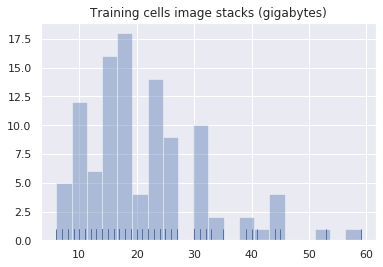

In [5]:
# bitwize shift 30 converts bytes to gigabytes
training_cell_sizes = np.array([cell["size"]>>30 for cell in training_neurons.values()])
sizes_histogram = sns.distplot(training_cell_sizes, bins=20, kde=False, rug=True).set_title("Training cells image stacks (gigabytes)")

In [6]:
# List cell sorted by fileset size (z-stack and SWC), plus averages and total

def sizer(x): 
  return training_neurons[x]["size"]

size_sorted = sorted(training_neurons, key = sizer) 
total_bytes_in_training_dataset = 0    
total_training_specimens = 0  
  
for a_neuron_name in size_sorted:
  total_training_specimens += 1
  a_neuron = training_neurons[a_neuron_name]
  fileSize, fileUnits = format_bytes(a_neuron["size"])
  total_bytes_in_training_dataset += a_neuron["size"]
  print(a_neuron_name + ": " + str(len(a_neuron["imagestack"])) + " files = " + '{:4.1f}'.format(fileSize) + " " + fileUnits )

average_specimen_size = total_bytes_in_training_dataset / total_training_specimens
average_size, averages_unit = format_bytes(average_specimen_size)

total_file_size, total_file_unit = format_bytes(total_bytes_in_training_dataset)
print("\nNumber of cells in training dataset = %d" % total_training_specimens)
print("Average cell data size = " + '{:4.1f}'.format(average_size) + " " + averages_unit + " (" + str(int(average_specimen_size)) + " bytes)")
print("Total size of training dataset = " + '{:4.1f}'.format(total_file_size) + " " + total_file_unit + " (" + str(total_bytes_in_training_dataset) + " bytes)")

651806289: 291 files =  6.0 GB
647289876: 228 files =  7.0 GB
651748297: 336 files =  7.0 GB
647244741: 261 files =  8.0 GB
713686035: 289 files =  8.9 GB
647247980: 299 files =  9.1 GB
649052017: 307 files =  9.4 GB
650917845: 245 files = 10.0 GB
672278613: 330 files = 10.1 GB
654221379: 334 files = 10.3 GB
676633030: 387 files = 10.6 GB
726555942: 377 files = 11.6 GB
706002308: 378 files = 11.6 GB
664466860: 382 files = 11.7 GB
739291676: 386 files = 11.9 GB
699207642: 389 files = 11.9 GB
669371214: 295 files = 12.0 GB
654591451: 300 files = 12.2 GB
836350796: 413 files = 12.7 GB
651511374: 414 files = 12.7 GB
729522604: 431 files = 13.2 GB
696228200: 435 files = 13.4 GB
651790667: 250 files = 13.4 GB
728251151: 267 files = 14.2 GB
668664690: 464 files = 14.3 GB
651834134: 469 files = 14.4 GB
673066511: 283 files = 14.5 GB
652113069: 359 files = 14.6 GB
821560343: 361 files = 14.7 GB
715286106: 482 files = 14.8 GB
739383450: 506 files = 15.6 GB
693978543: 386 files = 15.7 GB
72431640

In summary, there are 105 training neurons. The specimens' size range from 6.0 GB to 59.9 GB. Seven specimens are smaller than 10 GB.

### Map the 10 testing neuron
    
The final part of the challenge data set to be mapped is the sub-root directory, `TEST_DATA_SET`, which has 10 neurons laid out like with the training data, except the SWC files are missing i.e. no reconstruction answers given (because, that is what the challenger is supposed to demonstrate: the capability to generate quality SWC files).

In [7]:
client = boto3.client('s3',
     endpoint_url = 'https://s3.us-west-1.wasabisys.com',
     aws_access_key_id = '2G7POM6IZKJ3KLHSC4JB',
     aws_secret_access_key = "0oHD5BXPim7fR1n7zDXpz4YoB7CHAHAvFgzpuJnt")
paginator = client.get_paginator('list_objects')
result = paginator.paginate(
    Bucket='brightfield-auto-reconstruction-competition', 
    Prefix="TEST_DATA_SET/", 
    Delimiter='/')
    # See https://stackoverflow.com/a/36992023
    # A response can contain CommonPrefixes only if you specify a delimiter. When you do, CommonPrefixes contains all (if there are any) keys between Prefix and the next occurrence of the string specified by delimiter. In effect, CommonPrefixes lists keys that act like subdirectories in the directory specified by Prefix.

#for prefix in result.search('CommonPrefixes'):
#    print(prefix.get('Prefix'))
    
testing_neurons = {}

# Set up a progress indicator for this slow but not too slow task:
progressIndicator = display(progress(0, 10), display_id=True)
progressIndicator_count = 0
progressIndicator_end = 10

for o in result.search('CommonPrefixes'):
  progressIndicator_count += 1
  progressIndicator.update(progress(progressIndicator_count, progressIndicator_end))
  a_prefix = o.get("Prefix")
  print(a_prefix)
  
  # Enumerate all files
  # print("----------------")
  imagestack_bytes = 0
  imagestack = []
  swc_key = None
  for s3_object in bucket.objects.filter(Prefix = a_prefix):
    # print(s3_object.key + "= " + str(s3_object.size))
    if not s3_object.key.endswith(".swc"):
      if s3_object.key != a_prefix:
        # if == it's the directory itself, not a file in it so ignore
        imagestack.append(s3_object.key)
        imagestack_bytes += s3_object.size
    else:
      swc_key = s3_object.key
  
  # Strip the "TEST_DATA_SET/" and trailing "/" from Prefix
  neuron_id = a_prefix[len("TEST_DATA_SET/"):-1]
  
  testing_neurons[neuron_id] = {"prefix": a_prefix, "swc": swc_key, "imagestack": imagestack, "size": imagestack_bytes}
        
print( "# testing neurons mapped: " + str(len(testing_neurons)) + "\nSorted by size of image stack:")    
    
def testing_sizer(x): 
  return testing_neurons[x]["size"]

size_sorted_testing_neurons = sorted(testing_neurons, key = testing_sizer) 
total_bytes_in_testing_dataset = 0

for a_neuron_name in size_sorted_testing_neurons:
  a_neuron = testing_neurons[a_neuron_name]
  fileSize, fileUnits = format_bytes(a_neuron["size"])
  total_bytes_in_testing_dataset += a_neuron["size"]
  print(a_neuron_name + ": " + str(len(a_neuron["imagestack"])) + " files = " + '{:4.1f}'.format(fileSize) + " " + fileUnits )

fileSize, fileUnits = format_bytes(total_bytes_in_testing_dataset)
print("\nTotal size of testing dataset = " + '{:4.1f}'.format(fileSize) + " " + fileUnits )  

TEST_DATA_SET/665856925/
TEST_DATA_SET/687730329/
TEST_DATA_SET/691311995/
TEST_DATA_SET/715953708/
TEST_DATA_SET/741428906/
TEST_DATA_SET/751017870/
TEST_DATA_SET/761936495/
TEST_DATA_SET/827413048/
TEST_DATA_SET/850675694/
TEST_DATA_SET/878858275/
# testing neurons mapped: 10
Sorted by size of image stack:
665856925: 281 files =  8.6 GB
715953708: 340 files = 10.4 GB
751017870: 465 files = 18.9 GB
687730329: 497 files = 20.3 GB
850675694: 438 files = 23.5 GB
827413048: 424 files = 28.3 GB
761936495: 529 files = 28.5 GB
691311995: 441 files = 29.4 GB
741428906: 591 files = 39.4 GB
878858275: 541 files = 54.0 GB

Total size of testing dataset = 261.3 GB


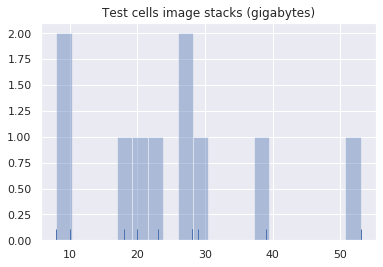

In [8]:
# bitwize shift 30 converts bytes to gigabytes
testing_cell_sizes = np.array([cell["size"]>>30 for cell in testing_neurons.values()])
sizes_histogram = sns.distplot(testing_cell_sizes, bins=20, kde=False, rug=True).set_title("Test cells image stacks (gigabytes)")

# Total dataset summary stats


In [17]:
# Note: specimen 741428906 is in both the training and testing datasets.
# This next line will keep the testing one, with prefix = 'TEST_DATA_SET/741428906/'.
# I.e. the training version of 741428906 is dropped from the manifest. We only
# have 10 test neurons, don't want to lose one. Although not much of a test if
# the answers are in the test question.
all_specimens = { **training_neurons, ** testing_neurons}

bytes_accum = 0
for specimen_name in all_specimens:
  specimen = all_specimens[specimen_name]
  bytes_accum += specimen["size"]
  # TODO: there must be a more elegant way to reduce an array in Python

print("Total bytes: %s" % bytes_accum)


grand_total_file_size, grand_total_file_unit = format_bytes(bytes_accum)
print("Number of cells in dataset manifest = %d" % len(all_specimens))
print("Total size of training dataset = " + '{:4.1f}'.format(grand_total_file_size) + " " + grand_total_file_unit + " (" + str(bytes_accum) + " bytes)")

Total bytes: 2671458682941
Number of cells in dataset manifest = 114
Total size of training dataset =  2.4 TB (2671458682941 bytes)


In [23]:
# Double check those numbers: just total every single object
total_bytes_for_all_objects = 0
for s3_object in bucket.objects.all():
  total_bytes_for_all_objects += s3_object.size
  
recheck_size, recheck_unit = format_bytes(total_bytes_for_all_objects)
print("Total size of all files in dataset = " + '{:4.2f}'.format(recheck_size) + " " + recheck_unit + " (" + str(total_bytes_for_all_objects) + " bytes)")

Total size of all files in dataset = 2.47 TB (2713810170427 bytes)


## Write specimens_manifest.json

The rest of the notebooks in this project make use of `specimens_manifest.json` which is just a semantically organized manifest of all the files in the dataset, organized by specimen, as image stack, catalogued by specimen_id. The head of `specimens_manifest.json` looks like:
```
{
    "647225829": {
        "id": "647225829",
        "bucket_prefix": "647225829/",
        "swc": "647225829/647225829.swc",
        "bytes": 26559180540,
        "image_stack": [
            "647225829/reconstruction_0_0539044533_639893239-0001.tif",
            "647225829/reconstruction_0_0539044533_639893239-0002.tif",
```

The file specimens_manifest.json is a logical view of the (~6K) physical files in the dataset. File names within the manifest are relative to the root of the dataset. This file can be used later to provide a clean interface to the library of specimens as well as maintain a per-specimen download cache (useful for notebooks that only process a single specimen because of file system size limitations). Having a download cache is very handy to speed up repeated notebook `Runtime | Run all` because each specimen's data is 6GB to 60GB in size, which is boring to watch happen repeatedly unneccessarily 

The specimens in the manifest JSON are listed in a flat dictionary, keyed by specimen ID. Filenames in the manifest are relative to the root of the bucket where the specimen dataset resides. 

(Note by file naming relative to the root of the original source dataset bucket (rather than Colab file system absolute names) folks could also use the specimens_manifest.json file outside the context of Colab. It is a reusable convenience for experimentation on other platforms.)

Each specimen has two properties, the local full filename to the .swc file (if any), and the array of full local filenames to the TIFF files in the z-stack.

The contents of specimens_manifest.json plus the directory name of root of the local file system cache of files from the dataset is sufficient to resolve to full file names of specimens files, with all the data corralling hassles already taken care of for code that actually does something with these files.

Might as well list the specimens sorted by size, smallest first. This way a casual tire kicker will grab the easiest/smallest specimen first. And files might as well be listed sorted alphbetically, which Python APIs do not guarantee.

Note: a copy of `specimens_manifest.json` is stored on reconstrue.com. This is used by default by other notebooks in this project. That file was created by the following code cell:

In [0]:
# Goal: write specimens_manifest.json
specimens_manifest = {}

# Set up data_dir, where to write to:
data_dir = "/content/brightfield_data/"
if not os.path.isdir(data_dir):
  os.mkdir(data_dir)
manifest_file_name = os.path.join(data_dir, "specimens_manifest.json")

for specimen_name in all_specimens:
  specimen = all_specimens[specimen_name]
  specimens_manifest[specimen_name] = {
    "id": specimen_name,
    "bucket_prefix": specimen["prefix"],
    "swc": specimen["swc"],
    "bytes": specimen["size"],
    "image_stack": specimen["imagestack"]
  } 
  # fields: {"imagestack": imagestack, "size": imagestack_bytes}

with open(manifest_file_name, "w+") as mani:
  json.dump(specimens_manifest, mani)


# Appendix #1: The curious case of specimen 741428906

Looks like 741428906 got into both the training and test datasets.

In [11]:
# Notice how len(all_specimens) < len(training_neurons) + len(testing_neurons)
# There seems to be one missing
print(len(training_neurons))
print(len(testing_neurons))
print(len(all_specimens))

# Notice how 741428906 is in both training and test subsets
aSet = set(training_neurons)
bSet = set(testing_neurons)
for name in aSet.intersection(bSet):
    print(name, all_specimens[name])



105
10
114
741428906 {'prefix': 'TEST_DATA_SET/741428906/', 'swc': None, 'imagestack': ['TEST_DATA_SET/741428906/reconstruction_0_0500371379_714485370-0001.tif', 'TEST_DATA_SET/741428906/reconstruction_0_0500371379_714485370-0002.tif', 'TEST_DATA_SET/741428906/reconstruction_0_0500371379_714485370-0003.tif', 'TEST_DATA_SET/741428906/reconstruction_0_0500371379_714485370-0004.tif', 'TEST_DATA_SET/741428906/reconstruction_0_0500371379_714485370-0005.tif', 'TEST_DATA_SET/741428906/reconstruction_0_0500371379_714485370-0006.tif', 'TEST_DATA_SET/741428906/reconstruction_0_0500371379_714485370-0007.tif', 'TEST_DATA_SET/741428906/reconstruction_0_0500371379_714485370-0008.tif', 'TEST_DATA_SET/741428906/reconstruction_0_0500371379_714485370-0009.tif', 'TEST_DATA_SET/741428906/reconstruction_0_0500371379_714485370-0010.tif', 'TEST_DATA_SET/741428906/reconstruction_0_0500371379_714485370-0011.tif', 'TEST_DATA_SET/741428906/reconstruction_0_0500371379_714485370-0012.tif', 'TEST_DATA_SET/741428906

In [12]:
# Check the file on the file system.
# On the file system, specimens_manifest.json is a bit long for display (> 5K lines). 
# So, here's the first 20 lines; the rest is similar.
!python -m json.tool {manifest_file_name} {manifest_file_name}".pretty.json"
!echo {data_dir}
!ls -l {data_dir}
!head -20 {manifest_file_name}".pretty.json"

/content/brightfield_data/
total 7012
-rw-r--r-- 1 root root 3266153 Nov 18 10:29 specimens_manifest.json
-rw-r--r-- 1 root root 3910364 Nov 18 10:29 specimens_manifest.json.pretty.json
{
    "647225829": {
        "id": "647225829",
        "bucket_prefix": "647225829/",
        "swc": "647225829/647225829.swc",
        "bytes": 26559180540,
        "image_stack": [
            "647225829/reconstruction_0_0539044533_639893239-0001.tif",
            "647225829/reconstruction_0_0539044533_639893239-0002.tif",
            "647225829/reconstruction_0_0539044533_639893239-0003.tif",
            "647225829/reconstruction_0_0539044533_639893239-0004.tif",
            "647225829/reconstruction_0_0539044533_639893239-0005.tif",
            "647225829/reconstruction_0_0539044533_639893239-0006.tif",
            "647225829/reconstruction_0_0539044533_639893239-0007.tif",
            "647225829/reconstruction_0_0539044533_639893239-0008.tif",
            "647225829/reconstruction_0_0539044533_639

## Next

[initial_dataset_visualization.ipynb](https://colab.research.google.com/drive/1ZxzDwD1UdYqhuTxckPLiOUYHin0MZmFQ#scrollTo=8ZiXCf_wflsU)


In [0]:
# To download specimens_manifest.json
# from google.colab import files
# files.download(manifest_file_name)